In [1]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

#import torch
#import torchvision
#import torch.nn as nn
#import torch.nn.functional as F

Version 2 new features:
- New feature detection: Low pitch low frequency fourier transform peak detection (to possibly find BPM?)
- Local pitch coherence:
    Local pitch coherence determined by variance of fft spectrum over a two second time period in a specific band, find means of these variances to determine the pitch coherence value for a frequency band

DATA PROCESSING

In [2]:
#returns the variance of the normalized data
def abs_div(data):
    data_norm = data/(np.max(data))
    data_abs = np.abs(data_norm)  
    data_avg = np.average(data_abs)
    data_var = np.power((data_abs - data_avg),2)
    return np.average(data_var)

In [3]:
#function for smoothing data
def smoothed(data):
    smooth = np.empty(data.size-400, dtype=float)
    for x in range(200,data.size-200):
        avg = np.average(data[x-200:x+200])
        smooth[x-200] = avg
    return smooth

In [4]:
def findMax(array):
    max = np.max(array)
    for x in range(0, array.size):
        if array[x] == max:
            return x
    return x

In [5]:
def dataProcessing(audio):
    #Inport audio file
    rate, data = wavfile.read(audio)

    #Output Data Array: 
    #Index 0: Average Intensity (relative to max)
    #Index 1: Variance of Normalized Intensity Data
    #Index 2-8: Relative Fractions of Average Freqency Intensities
    #Index 9-15: Variance of Normalized Frequency Band Intensity Data
    #Index 16-22: Local Squared Difference of Data and 400-sample Region for Frequency Bands
    #Index 23: BPM estimation off of low-frequency fourier peak
    output_data = np.empty(24, dtype=float)

    #changes data into usable format
    data = np.transpose(data)[0]
    #finds the absolute value of the normalized data, and then finds the average and inputs into the output array
    data_abs = np.abs(data/(np.max(data)))
    data_avg = np.average(data_abs)
    output_data[0] = data_avg
    #finds the variance of the normalized data, and then puts it into the output array
    output_data[1] = abs_div(data)

    #BPM analysis
    fft_out = fft(data)
    frequencies = np.linspace(0,1,len(data)) * rate
    cutoff_low = int((2 / rate * len(data)))
    cutoff = int((10 / rate) * len(data))
    beat_peak = findMax(fft_out[cutoff_low:cutoff]) + cutoff_low
    output_data[23] = frequencies[beat_peak]

    #converts spectrum into array of time and frequencies from fft
    spectrum, freqs, t, im = plt.specgram(data, Fs = rate, NFFT = 2000)

    #finds the rows which divide up the spectrum data into the frequency bands
    x = 0
    i = 1
    limits = np.empty(8, dtype=int)
    #gives a reference array for the sections 
    sections = [0,200,500,800,1500,2000,3000,np.max(freqs)]
    for r in freqs:
        if ((i == 1) & (r >= sections[1])):
            limits[1] = int(x)
            i += 1
        if ((i == 2) & (r >= sections[2])):
            limits[2] = int(x)
            i += 1
        if ((i == 3) & (r >= sections[3])):
            limits[3] = int(x)
            i += 1
        if ((i == 4) & (r >= sections[4])):
            limits[4] = int(x)
            i += 1
        if ((i == 5) & (r >= sections[5])):
            limits[5] = int(x)
            i += 1
        if ((i == 6) & (r >= sections[6])):
            limits[6] = int(x)
            i += 1
        x += 1
    #Ends of the limits array represent the bottom and upper ends of the sound spectrum
    limits[7] = int(freqs.size)
    limits[0] = 0

    #Create an array for the smoothed variance values of our dataset, and the relative intensity fractions of our bands
    smooth_vals = np.empty(7, dtype=float)
    intensity_fractions = np.empty(7, dtype=float)

    #Iterate through our frequency bands, performing calculations on different sections
    for x in range(0,7):
        #Copy the data for an array into another matrix, with the row transposed to represent all the data at a certain timepoint
        freq_data = np.transpose(np.array(spectrum[limits[x]:limits[x+1]]))
        #Sum up all of the data values for a specific timepoint to find the total for the frequency range at a given time
        range_intensity = np.empty(len(freq_data), dtype = float)
        for i in range(len(range_intensity)):
            range_intensity[i] = np.sum(freq_data[i])
        #Put the average total intensity for each range into the intensity fractions array
        intensity_fractions[x] = np.average(range_intensity)
        #Normalize range intensity after storing the relative average fractions
        range_intensity = range_intensity/(np.max(range_intensity))
        #Find the variance between the data and the smoothed data, determining how much intenisty varies for each frequency range
        smooth_diff = np.power(range_intensity[200:range_intensity.size-200] - smoothed(range_intensity), 2)
        #Average out the smoothed variance and send that to the smooth vals array
        smooth_vals[x] = np.average(smooth_diff)
        #Send the variance of the range_intensity normalized data to the output data array
        output_data[x+9] = abs_div(range_intensity)
    
    #Divide intensity fractions by their sum, in order to find relative frations
    intensity_fractions = intensity_fractions/np.sum(intensity_fractions)

    #Copy intensity fractions to output data
    n = 2
    for x in intensity_fractions:
        output_data[n] = x
        n += 1

    #Copy smooth vals to output data
    n = 16
    for x in smooth_vals:
        output_data[n] = x
        n += 1
    
    #Return our complete output data for analysis for the data sample
    return output_data


LOADS ALL DATA VALUES FOR REGRESSION

In [6]:
audio_EDM = ['Audio/EDM/01-dont-let-me-down_IBFUjKEE.wav', 'Audio/EDM/01-faded_ZkQNNMHm.wav','Audio/EDM/01-fractures-feat-nevve_nOvUVQHe.wav', 'Audio/EDM/01-friends_qvpJ4Lo4.wav', 'Audio/EDM/01-good-things-fall-apart-with-jon-bellion_xpYFEBMe.wav', 'Audio/EDM/01-happier_GNrA2lNl.wav', 'Audio/EDM/01-ignite-2016-league-of-legends-world-championship_4NqYagH7.wav', 'Audio/EDM/01-in-the-name-of-love_jKlJDXPg.wav', 'Audio/EDM/01-legends-never-die_5mDvGncl.wav', 'Audio/EDM/01-monody-feat-laura-brehm_qU3F5YI0.wav', 'Audio/EDM/01-never-be-alone_Jv12eRl8.wav', 'Audio/EDM/01-silence_qpg8yd6l.wav', 'Audio/EDM/01-stay-with-justin-bieber_ltjXbsxI.wav', 'Audio/EDM/01-sweet-dreams_e3fA34lv.wav', 'Audio/EDM/01-this-is-what-you-came-for_InpQYKrj.wav', 'Audio/EDM/01-titanium-feat-sia_aQb8tAes.wav', 'Audio/EDM/01-wake-me-up_KuOoUs4s.wav', 'Audio/EDM/02-animals_pk7DZset.wav', 'Audio/EDM/02-the-nights_VYEGBCc5.wav', 'Audio/EDM/08-summer_IiUQlAi9.wav']
audio_Acoustic = ['Audio/Acoustic/01-beside-you_DbI1HoZp.wav', 'Audio/Acoustic/01-blue-jeans_KtEm5Rew.wav', 'Audio/Acoustic/01-comethru_xaPhmWu1.wav', 'Audio/Acoustic/01-every-summertime_JhqMP4vf.wav', 'Audio/Acoustic/01-forever_I7GFvUWO.wav', 'Audio/Acoustic/01-glimpse-of-us_eaUMFHHd.wav', 'Audio/Acoustic/01-i-love-you-3000_MhUDZ0Tw.wav', 'Audio/Acoustic/01-its-you_F8gy2m2i.wav', 'Audio/Acoustic/01-lowkey_l70yk4Kc.wav', 'Audio/Acoustic/01-over-85_qAs8hOpI.wav', 'Audio/Acoustic/01-paragraphs_YX95fhg4.wav', 'Audio/Acoustic/02-all-the-stars-with-sza_scR5myEg.wav', 'Audio/Acoustic/02-idk-you-yet_rw1jHoGu.wav', 'Audio/Acoustic/02-paris-in-the-rain_upCjJwOS.wav', 'Audio/Acoustic/02-slow-dancing-in-the-dark_7DuXBFev.wav', 'Audio/Acoustic/03-blue_bizdmoGR.wav', 'Audio/Acoustic/03-nothing_FvdnRUPW.wav', 'Audio/Acoustic/05-scared_9tLiNUgS.wav', 'Audio/Acoustic/06-heartbreak-anniversary_EGZ7xVAV.wav', 'Audio/Acoustic/06-when-i-was-your-man_QLPuoeTU.wav']
audio_HipHop = ['Audio/Hip Hop/01-broccoli_T8E78OZY.wav', 'Audio/Hip Hop/01-highest-in-the-room_St5D6Qyd.wav', 'Audio/Hip Hop/01-industry-baby-feat-jack-harlow_WcNnacu6.wav', 'Audio/Hip Hop/01-trap-queen_8G2DO5e0.wav', 'Audio/Hip Hop/01-whats-poppin_s84KOU9F.wav', 'Audio/Hip Hop/02-bank-account_1tzsEOaC.wav', 'Audio/Hip Hop/02-rapstar_KzWdE0Dp.wav', 'Audio/Hip Hop/03-goin-baby_vdwhRP6r.wav', 'Audio/Hip Hop/03-lucid-dreams_Re1GBOPz.wav', 'Audio/Hip Hop/03-ni-as-in-paris_4Gd5Qr2o.wav', 'Audio/Hip Hop/04-sad_4MGXMNw7.wav', 'Audio/Hip Hop/04-sad_4MGXMNw7.wav', 'Audio/Hip Hop/05-black-beatles_4P3MObDG.wav', 'Audio/Hip Hop/05-dollaz-on-my-head-feat-young-thug_rZnBd4vw.wav', 'Audio/Hip Hop/05-go-stupid_JX0u37ij.wav', 'Audio/Hip Hop/05-gods-plan_npCgxuP6.wav', 'Audio/Hip Hop/07-burning-up-feat-the-kid-laroi_glVulTwh.wav', 'Audio/Hip Hop/07-godzilla-feat-juice-wrld_HyXxbZYa.wav', 'Audio/Hip Hop/07-let-it-eat-feat-ugly-god_hy86qqow.wav', 'Audio/Hip Hop/09-mo-bamba_qkqDH4UF.wav', 'Audio/Hip Hop/14-jimmy-cooks-feat-21-savage_5IZHBAha.wav']

/Users/ashish/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7626: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


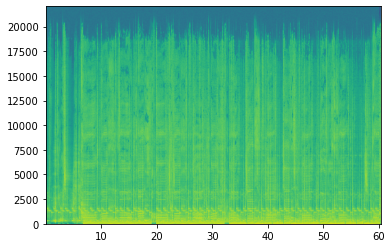

In [7]:
#Genres: 0 - EDM, 1 - Acoustic, 2 - Hip Hop
x = 20
total_data = np.empty(shape = [3, x, 24], dtype=float)

#Load in data for EDM
for i in range(0,x):
    total_data[0][i] = dataProcessing(audio_EDM[i])

#Load in data for Acoustic
for i in range(0,x):
    total_data[1][i] = dataProcessing(audio_Acoustic[i])

#Load in data for Hip_Hop
for i in range(0,x):
    total_data[2][i] = dataProcessing(audio_HipHop[i])


CALCULATE MEANS AND VARIANCE

In [8]:
#Array stores the means for each of the genres
genre_means = np.empty(shape=[3,24], dtype=float)
for i in range(0,3):
    genre_means[i] = np.mean(total_data[i], axis = 0)
total_means = np.empty(24, dtype=float)
#Stores total means for all data
total_means = np.mean(genre_means, axis = 0)
print("genre means:")
print (genre_means)

genre means:
[[0.2162829  0.03196743 0.50687141 0.15265103 0.09627582 0.11760689
  0.03148416 0.03173386 0.06337682 0.03137906 0.0174691  0.0113951
  0.01321722 0.01073266 0.01199133 0.01876452 0.02098925 0.01655548
  0.01062351 0.01141003 0.01041399 0.01115228 0.01527947 6.22709536]
 [0.1880222  0.02900467 0.45414382 0.29105775 0.12745653 0.0778908
  0.01790274 0.01285403 0.01869433 0.02224036 0.01628871 0.01615128
  0.01524328 0.00924257 0.00870424 0.0112453  0.01870259 0.01604807
  0.01446254 0.01466535 0.00965618 0.00851288 0.01138898 5.58583544]
 [0.21002195 0.03615986 0.71012747 0.08292814 0.06615603 0.05649528
  0.01837817 0.01980488 0.04611003 0.03722429 0.01200315 0.01835606
  0.01440795 0.01140212 0.0109892  0.01910172 0.03292207 0.01191859
  0.0176215  0.01417526 0.01200513 0.01173623 0.02002008 5.6284527 ]]


In [9]:
def var_calc(mean, values):
    return np.average(np.power((values - mean),2))

In [10]:
#Array stores variance from means for each of the genres
genre_vars = np.empty(shape=[3,24], dtype=float)
for i in range(0,3):
    for n in range(0,24):
        genre_vars[i][n] = var_calc(genre_means[i][n], np.transpose(total_data[i])[n])
#Stores variance for all data vs total means
genreless_data = np.empty(shape=[3*x, 24])
for i in range(0,3):
    for n in range(0,x):
        genreless_data[3*i + n] = total_data[i][n]
total_vars = np.empty(24, dtype=float)
for i in range(0, 24):
    total_vars[i] = var_calc(total_means[i], np.transpose(genreless_data)[i] )

genre_stds = np.empty(shape=[3,24], dtype=float)
genre_stds = np.power(genre_vars, 0.5)
genre_averaged_stds = np.mean(genre_stds, axis=0)
print("genre standard deviations:")
print (genre_stds)
print("genre averaged standard deviations:")
print (genre_averaged_stds)


genre standard deviations:
[[0.03395556 0.00508794 0.11184392 0.05458196 0.03761151 0.04731999
  0.01172342 0.00895194 0.02702268 0.01179748 0.00568008 0.00537827
  0.00434245 0.00547643 0.00420402 0.00983298 0.00982461 0.00577021
  0.00465646 0.00485454 0.00560351 0.00474109 0.00880995 2.71438753]
 [0.04374904 0.00916117 0.20167792 0.14577757 0.05981617 0.05613794
  0.01053784 0.00667409 0.01462732 0.01214444 0.00775316 0.00791313
  0.00934232 0.0051244  0.00570482 0.00482136 0.01124321 0.00802836
  0.00780027 0.00899489 0.0055271  0.00609687 0.00538794 2.26133204]
 [0.0476461  0.0104747  0.12119574 0.03523659 0.03818409 0.02898451
  0.01620899 0.01365985 0.03394387 0.01950115 0.00470573 0.00656142
  0.00436847 0.00421429 0.00358294 0.00672712 0.02037991 0.00515955
  0.00670117 0.00430436 0.0043703  0.00377194 0.0083746  2.36992802]]
genre averaged standard deviations:
[0.04178357 0.00824127 0.14490586 0.07853204 0.04520392 0.04414748
 0.01282341 0.00976196 0.02519796 0.01448103 0.006

CALCULATE WEIGHTING BASED ON APPROXIMATE Z-SCORES
Assumption: variance stays approximately the same between different genres

In [11]:
#Determines weightings for final score based on weights, according to data distance to genre means vs averaged standard deviations
def weighting(means, vars):
    #return np.abs(means[1]-means[0])/((vars[0] + vars[1]) * 0.5) + np.abs(means[2] - means[0])/((vars[0] + vars[2]) * 0.5) + np.abs(means[2] - means[1])/((vars[1] + vars[2]) * 0.5)
    return (np.abs(means[1]-means[0]) + np.abs(means[2] - means[0]) + np.abs(means[2] - means[1]))/vars

In [12]:
weights = np.empty(24, dtype=float)
for i in range(0, 24):
    #weights[i] = weighting(np.transpose(genre_means)[i], np.transpose(genre_vars)[i])
    weights[i] = weighting(np.transpose(genre_means)[i], genre_averaged_stds[i])
print(weights)

[1.35271872 1.73642853 3.53310287 5.30050178 2.71217631 2.76852094
 2.11822305 3.86804051 3.54651695 2.0694572  1.80802293 2.10377013
 0.67336267 0.8746004  1.46182067 2.204643   2.0584201  1.46751456
 2.19167547 1.07591453 0.90921547 1.32376925 2.29423374 0.52378765]


In [13]:
def findMin(array):
    max = np.min(array)
    for x in range(0, array.size):
        if array[x] == max:
            return x
    return x

In [14]:
def guess(weights, audio, genre_means):
    data = dataProcessing(audio)
    scores = np.empty(3, dtype = float)
    for x in range(0,3):
        score = 0
        for i in range (0,4):
            score = score + weights[i] * np.power(np.abs(data[i] - genre_means[x][i]), 2)
        scores[x] = score
    return scores

TESTING REGRESSION WITH TRAINING DATA

EDM fail scores:
[0.06969324 0.01951783 0.43627982]
[0.26431743 0.12486526 0.85786995]
[0.19025041 0.48423561 0.00120594]
[0.26809153 0.09531542 0.85225991]
R&B/Soul fail scores:
[0.01511341 0.05140302 0.2754275 ]
[0.32777714 0.5865205  0.04655117]
[0.07291214 0.09328311 0.17146773]
[0.00778846 0.15442122 0.10996714]
[0.14811707 0.22670474 0.11343045]
[0.14656853 0.39296583 0.0061036 ]
[0.00714376 0.1734476  0.13829607]
[0.17415618 0.46700237 0.00304091]
Hip Hop fail scores:
[0.14836955 0.33217512 0.48681398]
[0.04808143 0.18939821 0.06449581]
[0.04808143 0.18939821 0.06449581]
pass: 45
fail: 15


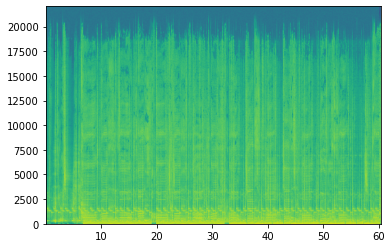

In [15]:
p = 0
f = 0
x = 20
print("EDM fail scores:")
for i in range(0,x):
    scores = guess(weights, audio_EDM[i], genre_means)
    if (findMin(scores)== 0):
        p += 1
    else:
        print(scores)
        f += 1
print("R&B/Soul fail scores:")
for i in range(0,x):
    scores = guess(weights, audio_Acoustic[i], genre_means)
    if (findMin(scores) == 1):
        p += 1
    else:
        print(scores)
        f += 1
print("Hip Hop fail scores:")
for i in range(0,x):
    scores = guess(weights, audio_HipHop[i], genre_means)
    if (findMin(scores) == 2):
        p += 1
    else:
        print(scores)
        f += 1

print ("pass: " + str(p))
print ("fail: " + str(f))

weights below are using average variance for weight calculation (pass = 46, fail = 14):

[1.35271872, 0.00824127, 0.14490586, 0.07853204, 0.04520392, 0.04414748, 0.01282341, 0.00976196, 0.02519796, 0.01448103, 0.00604632, 0.00661761,0.00601775, 0.00493837, 0.00449726, 0.00712715, 0.01381591, 0.00631938,0.00638597, 0.00605126, 0.00516697, 0.00486996, 2.29423374]

weights below are using specific genre variance for weight calculation (pass = 41, fail = 19):

[3.26029762e+01 3.28703869e-02 7.27600756e-01 1.01011955e-01 7.09934676e-02 6.09797937e-02 1.23865304e-02 6.47795437e-03 2.05495427e-02 2.96804083e-02 1.07876187e-02 1.12997996e-02 8.21982829e-03 1.33788138e-02 1.12549632e-02 1.61588314e-02 1.65151195e-02 9.20913113e-03 1.10420659e-02 7.51531267e-03 1.32203285e-02 1.23102844e-02 3.11209934e+02]

weights below are including bpm calculations using average variance for weight calculation (pass = 45, fail = 15):
[1.35271872 1.73642853 3.53310287 5.30050178 2.71217631 2.76852094
 2.11822305 3.86804051 3.54651695 2.0694572  1.80802293 2.10377013
 0.67336267 0.8746004  1.46182067 2.204643   2.0584201  1.46751456
 2.19167547 1.07591453 0.90921547 1.32376925 2.29423374 0.52378765]

TESTING DATA TESTING BELOW
- Ocho Cinco - EDM (full clip): Pass
- Paramedic! - Hip Hop (full clip): Pass
- Sunrise - Acoustic (full clip): Fail (Determined as Hip Hop, is technically lofi??)
- Tremors - EDM (full clip): Fail (Determined as Hip Hop)
- EA - Hip Hop (full clip): Pass

pass


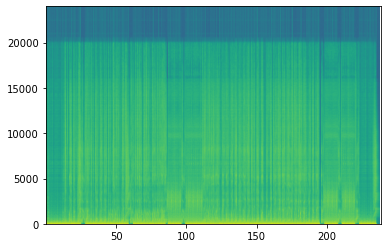

In [16]:
test_audio = 'Audio/Testing/Nonstop_(getmp3.pro).wav'
genre = 2
scores = guess(weights, test_audio, genre_means)
if (findMin(scores) == genre):
    print('pass')
else:
    print('fail')

VALIDATION TESTING

In [17]:
test_audio_EDM = ['Audio/Testing/05 Clarity.wav', 'Audio/Testing/07 Don\'t You Worry Child.wav', 'Audio/Testing/03 We Found Love.wav', 'Audio/Testing/01 Turn Down for What.wav', 'Audio/Testing/03 Feel So Close - Radio Edit.wav']
test_audio_RB = ['Audio/Testing/01 CHICKEN TENDIES.wav', 'Audio/Testing/03 Die For You.wav', 'Audio/Testing/07-Talking-to-the-Moon.wav', 'Audio/Testing/01 Shouldn\'t Be.wav', 'Audio/Testing/04 Nothing\'s the Same.wav']
test_audio_HipHop = ['Audio/Testing/01 Gorilla Grip.wav', 'Audio/Testing/03 Diamonds Dancing (feat. Travis Scott).wav', 'Audio/Testing/04 wokeuplikethis.wav', 'Audio/Testing/18-Monëy-so-big.wav', 'Audio/Testing/04 EA (feat. 21 Savage)_1.wav']

EDM fail scores:
[0.11370824 0.10040734 0.56101164]
[0.20047465 0.55487736 0.02051517]
R&B/Soul fail scores:
[0.0820269  0.21752628 0.06086585]
Hip Hop fail scores:
pass: 12
fail: 3


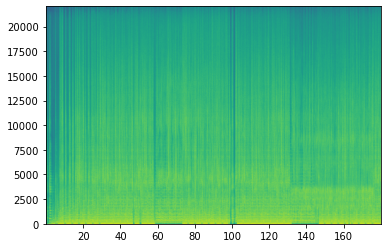

In [18]:
p = 0
f = 0
x = 5
print("EDM fail scores:")
for i in range(0,x):
    scores = guess(weights, test_audio_EDM[i], genre_means)
    if (findMin(scores)== 0):
        p += 1
    else:
        print(scores)
        f += 1
print("R&B/Soul fail scores:")
for i in range(0,x):
    scores = guess(weights, test_audio_RB[i], genre_means)
    if (findMin(scores) == 1):
        p += 1
    else:
        print(scores)
        f += 1
print("Hip Hop fail scores:")
for i in range(0,x):
    scores = guess(weights, test_audio_HipHop[i], genre_means)
    if (findMin(scores) == 2):
        p += 1
    else:
        print(scores)
        f += 1

print ("pass: " + str(p))
print ("fail: " + str(f))

RESULTS GRAPHS

Text(0.5, 1.0, 'Weighting of Different Data Factors')

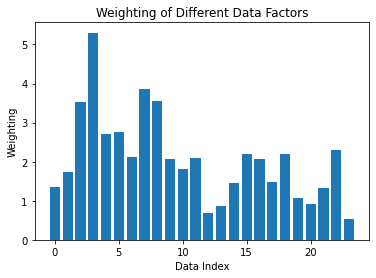

In [19]:
plt.bar(np.arange(24),weights)
plt.xlabel("Data Index")
plt.ylabel("Weighting")
plt.title("Weighting of Different Data Factors")

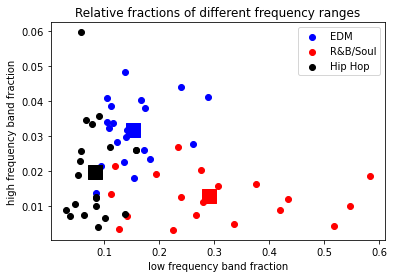

In [20]:
plt.scatter(np.transpose(total_data[0])[3], np.transpose(total_data[0])[7], c='blue', label='EDM')
plt.scatter(genre_means[0][3], genre_means[0][7], c='blue', s=200, marker='s')
plt.scatter(np.transpose(total_data[1])[3], np.transpose(total_data[1])[7], c='red', label='R&B/Soul')
plt.scatter(genre_means[1][3], genre_means[1][7], c='red', s=200, marker='s')
plt.scatter(np.transpose(total_data[2])[3], np.transpose(total_data[2])[7], c='black', label='Hip Hop')
plt.scatter(genre_means[2][3], genre_means[2][7], c='black', s=200, marker='s')
plt.xlabel("low frequency band fraction")
plt.ylabel("high frequency band fraction")
plt.title("Relative fractions of different frequency ranges")
plt.legend()

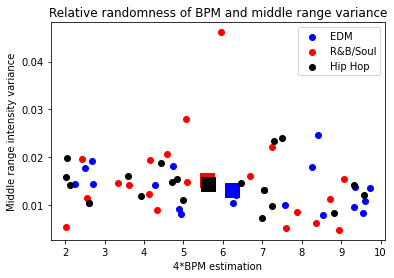

In [21]:
plt.scatter(np.transpose(total_data[0])[23], np.transpose(total_data[0])[12], c='blue', label='EDM')
plt.scatter(genre_means[0][23], genre_means[0][12], c='blue', s=200, marker='s')
plt.scatter(np.transpose(total_data[1])[23], np.transpose(total_data[1])[12], c='red', label='R&B/Soul')
plt.scatter(genre_means[1][23], genre_means[1][12], c='red', s=200, marker='s')
plt.scatter(np.transpose(total_data[2])[23], np.transpose(total_data[2])[12], c='black', label='Hip Hop')
plt.scatter(genre_means[2][23], genre_means[2][12], c='black', s=200, marker='s')
plt.xlabel("4*BPM estimation")
plt.ylabel("Middle range intensity variance")
plt.title("Relative randomness of BPM and middle range variance")
plt.legend()